<a href="https://colab.research.google.com/github/Victor-techh/Learn-Python/blob/main/data-solutions/olist/Analise_Estrategica_Olist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. importes
import pandas as pd
import sqlite3
import os #nao foi usado em nenhum momento deste codigo
from google.colab import drive

# 2. Conectar ao Drive e definir caminhos
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Projeto_Olist/'

# 3. Carregar os CSVs do Drive para a memória (Define as variáveis)
try:
    print("⏳ Carregando arquivos do Drive...")
    df_orders = pd.read_csv(path + 'olist_orders_dataset.csv', sep=';')
    df_items = pd.read_csv(path + 'olist_order_items_dataset.csv', sep=',')
    df_customers = pd.read_csv(path + 'olist_customers_dataset.csv', sep=',')
    df_products = pd.read_csv(path + 'olist_products_dataset.csv', sep=',')
    df_category = pd.read_csv(path + 'product_category_name_translation.csv', sep=',')

    # 3.1 AJUSTE ESSENCIAL: Convertendo as 3 colunas de data necessárias
    colunas_data = [
        'order_purchase_timestamp',
        'order_delivered_customer_date',
        'order_estimated_delivery_date'
    ]

    for col in colunas_data:
        # errors='coerce' transforma datas inválidas em "vazio" (NaT) em vez de dar erro
        df_orders[col] = pd.to_datetime(df_orders[col], dayfirst=True, errors='coerce')

    print("✅ Arquivos carregados e DATAS corrigidas na memória!")

    # 3.2 Salvando no Banco de Dados Persistente
    conn = sqlite3.connect(path + 'olist_projeto_final.db')
    df_orders.to_sql('orders', conn, if_exists='replace', index=False)
    df_items.to_sql('items', conn, if_exists='replace', index=False)
    df_customers.to_sql('customers', conn, if_exists='replace', index=False)
    df_products.to_sql('products',conn, if_exists='replace', index=False)
    df_category.to_sql('category', conn, if_exists='replace', index=False)
    print("💾 Banco 'olist_projeto_final.db' atualizado com as datas corretas!")

except Exception as e:
    print(f"❌ Erro na carga: {e}")

Mounted at /content/drive
⏳ Carregando arquivos do Drive...
✅ Arquivos carregados e DATAS corrigidas na memória!
💾 Banco 'olist_projeto_final.db' atualizado com as datas corretas!


Os dados utilizados são oficiais e foram disponibilizados publicamente pela empresa através do Kaggle (Brazilian E-Commerce Public Dataset by Olist). O objetivo é diagnosticar as causas de uma taxa de Churn elevada através da ótica logística e financeira.

O link dos dados estão salvos na pasta do drive mount.



--- DISTRIBUIÇÃO DE CHURN ---
Ativo: 9 clientes (0.01%)
Alerta: 9684 clientes (9.74%)
Churn: 89748 clientes (90.25%)


/tmp/ipython-input-2151002402.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=contagem.index, y=contagem.values, palette='viridis')


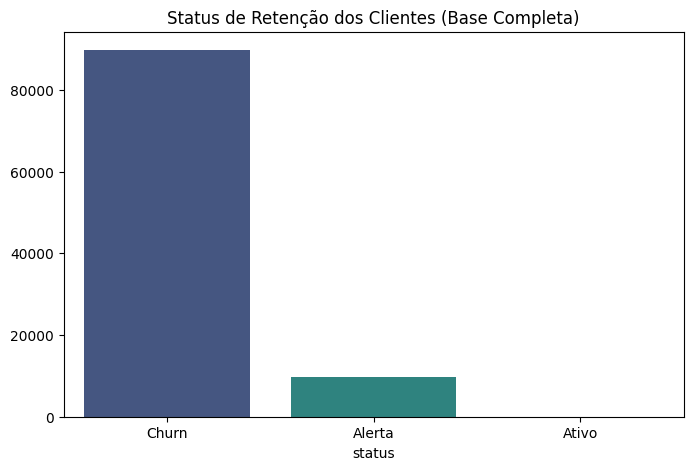

In [ ]:
# Projeto 1 Análise de Churn


import matplotlib.pyplot as plt
import seaborn as sns

# 1. Cálculo de Churn via SQL
query_churn = """
SELECT
    customer_id,
    MAX(order_purchase_timestamp) AS ultima_compra,
    CAST(JULIANDAY('2018-10-18') - JULIANDAY(MAX(order_purchase_timestamp)) AS INT) AS dias_sem_comprar
FROM orders
GROUP BY customer_id
"""
df_churn = pd.read_sql(query_churn, conn)

# 2. Classificação
def rotular(dias):
    if dias <= 30: return 'Ativo'
    elif dias <= 90: return 'Alerta'
    else: return 'Churn'

df_churn['status'] = df_churn['dias_sem_comprar'].apply(rotular)

# 3. Resultados e Gráfico
contagem = df_churn['status'].value_counts()
porcentagem = df_churn['status'].value_counts(normalize=True) * 100

print("--- DISTRIBUIÇÃO DE CHURN ---")
for s in ['Ativo', 'Alerta', 'Churn']:
    print(f"{s}: {contagem[s]} clientes ({porcentagem[s]:.2f}%)")

plt.figure(figsize=(8, 5))
sns.barplot(x=contagem.index, y=contagem.values, palette='viridis')
plt.title('Status de Retenção dos Clientes (Base Completa)')
plt.show()

Acima temos o tamanho do Churn da operação.

Os dados mostram que o Churn está na casa dos 90%, o que evidencia a enorme dificuldade de fidelizar clientes. Esse índice indica que a vasta maioria da base não realiza uma nova compra há mais de 90 dias.

O grupo em Alerta (9%) representa clientes que ainda são considerados da base, mas que não compram há mais de 30 dias, indicando um risco iminente de perda caso não haja uma ação de retenção.

Por fim, a taxa de 0,01% de clientes Ativos é o dado mais alarmante: ele revela que apenas uma fração mínima da base realizou compras nos últimos 30 dias. Mais do que apenas '9 clientes', esse número prova que a Olist sobrevive de atrair constantemente novos consumidores, mas falha em mantê-los ativos após a primeira experiência.


/tmp/ipython-input-3241948694.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_logistica, x='customer_state', y='pct_frete_medio', ax=ax[0], palette='coolwarm')
/tmp/ipython-input-3241948694.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_logistica, x='customer_state', y='media_atraso_dias', ax=ax[1], palette='Reds_r')


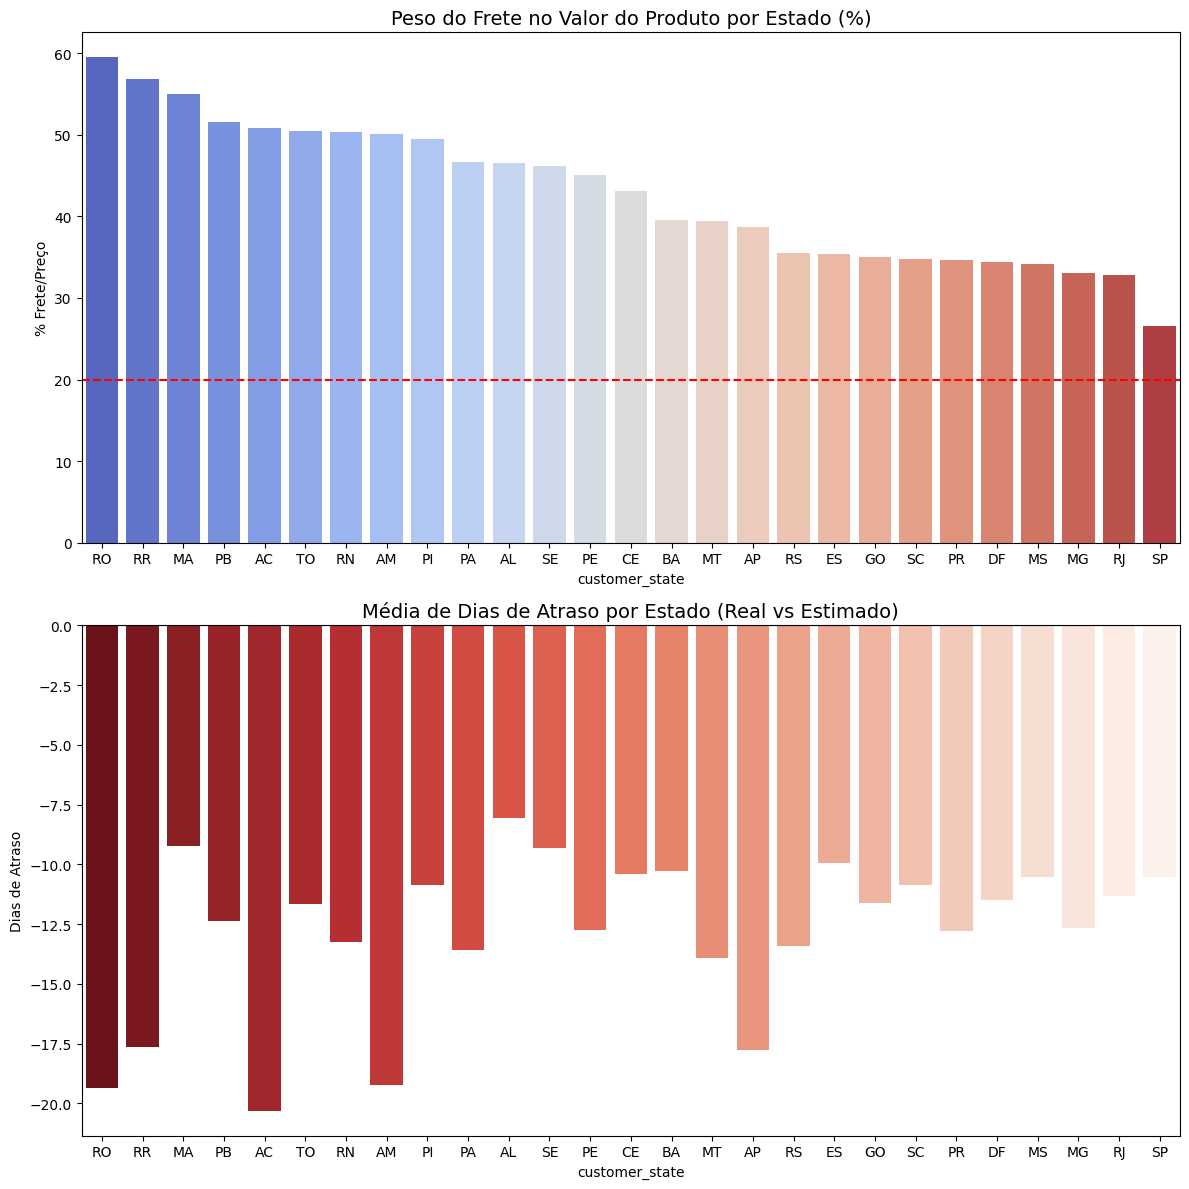

--- ESTADOS COM MAIOR IMPACTO LOGÍSTICO (FRETE + ATRASO) ---
  customer_state  pct_frete_medio  media_atraso_dias
0             RO        59.576108         -19.341484
1             RR        56.827791         -17.618765
2             MA        54.990936          -9.225428
3             PB        51.525824         -12.371969
4             AC        50.831149         -20.333219


In [ ]:
# 1. Query SQL: Unindo Frete, Atrasos e Localização

query_logistica = """
SELECT
    c.customer_state,
    AVG((i.freight_value / i.price) * 100) AS pct_frete_medio,
    AVG(JULIANDAY(o.order_delivered_customer_date) - JULIANDAY(o.order_estimated_delivery_date)) AS media_atraso_dias
FROM orders o
JOIN items i ON o.order_id = i.order_id
JOIN customers c ON o.customer_id = c.customer_id
WHERE o.order_status = 'delivered'
  AND o.order_delivered_customer_date IS NOT NULL
GROUP BY c.customer_state
ORDER BY pct_frete_medio DESC
"""

df_logistica = pd.read_sql(query_logistica, conn)

# 2. Visualização Dupla
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# Gráfico A: Peso do Frete por Estado
sns.barplot(data=df_logistica, x='customer_state', y='pct_frete_medio', ax=ax[0], palette='coolwarm')
ax[0].axhline(20, color='red', linestyle='--', label='Limite Crítico (20%)')
ax[0].set_title('Peso do Frete no Valor do Produto por Estado (%)', fontsize=14)
ax[0].set_ylabel('% Frete/Preço')

# Gráfico B: Atrasos Médios por Estado
sns.barplot(data=df_logistica, x='customer_state', y='media_atraso_dias', ax=ax[1], palette='Reds_r')
ax[1].axhline(0, color='black', linestyle='-')
ax[1].set_title('Média de Dias de Atraso por Estado (Real vs Estimado)', fontsize=14)
ax[1].set_ylabel('Dias de Atraso')

plt.tight_layout()
plt.show()

# 3. Exibição dos 5 estados mais críticos
print("--- ESTADOS COM MAIOR IMPACTO LOGÍSTICO (FRETE + ATRASO) ---")
print(df_logistica.head(5))

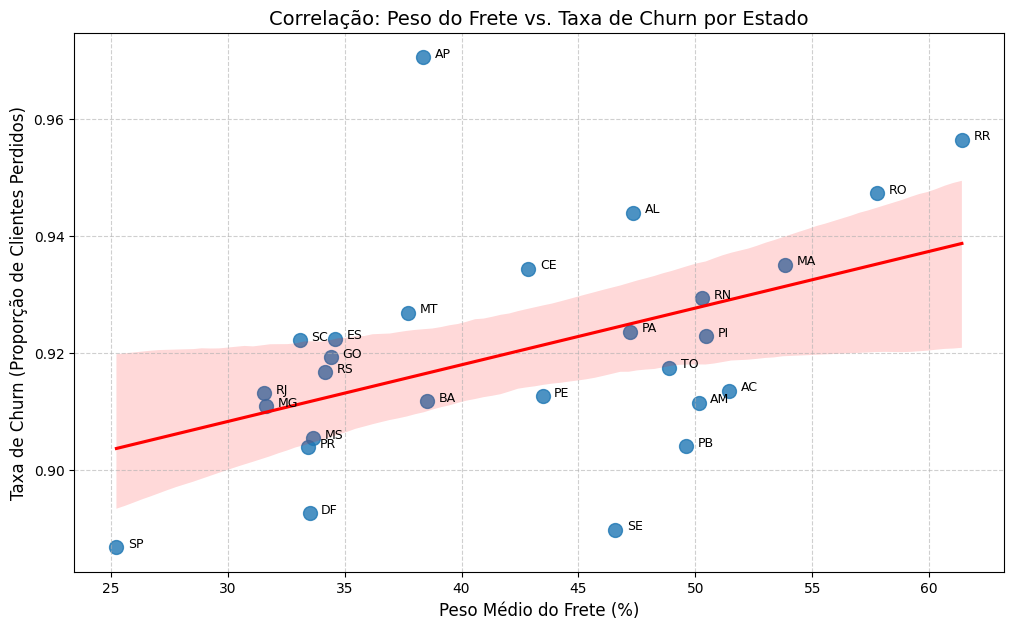

Coeficiente de Correlação de Pearson: 0.47


In [ ]:
#Correlação Frete vs. Churn por Estado

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. SQL: Buscando dados de Churn, Frete e Estado em uma única visão
query_correlacao = """
SELECT
    c.customer_state,
    o.customer_id,
    MAX(o.order_purchase_timestamp) AS ultima_compra,
    AVG((i.freight_value / i.price) * 100) AS pct_frete
FROM orders o
JOIN items i ON o.order_id = i.order_id
JOIN customers c ON o.customer_id = c.customer_id
WHERE i.price > 0
GROUP BY o.customer_id
"""
df_corr = pd.read_sql(query_correlacao, conn)

# 2. Definindo quem é Churn (Mais de 90 dias sem comprar)
df_corr['is_churn'] = df_corr['ultima_compra'].apply(
    lambda x: 1 if (pd.to_datetime('2018-10-18') - pd.to_datetime(x)).days > 90 else 0
)

# 3. Agrupando por Estado para ver a Correlação
df_estado = df_corr.groupby('customer_state').agg({
    'pct_frete': 'mean',
    'is_churn': 'mean' # Isso gera a % de churn por estado
}).reset_index()

# 4. Gráfico de Dispersão (Scatter Plot)
plt.figure(figsize=(12, 7))
sns.regplot(data=df_estado, x='pct_frete', y='is_churn', scatter_kws={'s':100}, line_kws={"color": "red"})

# Adicionando os nomes dos estados nos pontos
for i in range(df_estado.shape[0]):
    plt.text(df_estado.pct_frete[i]+0.5, df_estado.is_churn[i],
             df_estado.customer_state[i], fontsize=9)

plt.title('Correlação: Peso do Frete vs. Taxa de Churn por Estado', fontsize=14)
plt.xlabel('Peso Médio do Frete (%)', fontsize=12)
plt.ylabel('Taxa de Churn (Proporção de Clientes Perdidos)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 5. Cálculo Matemático da Correlação (Coeficiente de Pearson)
correlacao = df_estado['pct_frete'].corr(df_estado['is_churn'])
print(f"Coeficiente de Correlação de Pearson: {correlacao:.2f}")

O Paradoxo Logístico

Identificamos uma estratégia de "Prazos Gordos", onde a empresa estima prazos longos e entrega muito antes do previsto (chegando a 20 dias de antecedência no Norte). Contudo, a análise de correlação prova que a agilidade não compensa o custo: o frete representa até 60% do valor do produto em estados como RO e RR.

Veredito

O Churn é impulsionado pelo Custo Brasil. A experiência de entrega é positiva em termos de tempo, mas a barreira financeira do frete impede que o comprador de oportunidade se torne um cliente recorrente.

In [ ]:
# Projeto 2: Performance de Vendas e Mix de Produtos

  # O objetivo é identificar quais categorias de produtos trazem o grosso do
  # faturamento. Na regra de negócio, geralmente 20% das categorias geram 80% do
  # dinheiro.

# Query para o nosso novo desafio: Performance por Categoria
query_abc = """
SELECT
    p.product_category_name AS categoria,
    ROUND(SUM(i.price), 2) AS faturamento,
    COUNT(i.order_id) AS total_vendas
FROM items i
JOIN products p ON i.product_id = p.product_id
GROUP BY 1
ORDER BY faturamento DESC
"""
df_abc = pd.read_sql(query_abc, conn)
df_abc['percentual_acumulado'] = (df_abc['faturamento'].cumsum() / df_abc['faturamento'].sum()) * 100
df_abc.head(10)

,categoria,faturamento,total_vendas,percentual_acumulado
0,beleza_saude,1258681.34,9670,9.260700
1,relogios_presentes,1205005.68,5991,18.126483
2,cama_mesa_banho,1036988.68,11115,25.756088
3,esporte_lazer,988048.97,8641,33.025621
4,informatica_acessorios,911954.32,7827,39.735290
5,moveis_decoracao,729762.49,8334,45.104489
6,cool_stuff,635290.85,3796,49.778618
7,utilidades_domesticas,632248.66,6964,54.430363
8,automotivo,592720.11,4235,58.791278
9,ferramentas_jardim,485256.46,4347,62.361534


In [ ]:
# Query com JOIN na tabela de tradução para um relatório profissional

query_vendas_traduzida = """
SELECT
    pc.product_category_name_english AS categoria,
    ROUND(SUM(i.price), 2) AS faturamento
FROM items i
JOIN products p ON i.product_id = p.product_id
JOIN category pc ON p.product_category_name = pc.product_category_name
GROUP BY 1
ORDER BY faturamento DESC
"""
df_vendas_final = pd.read_sql(query_vendas_traduzida, conn)
df_vendas_final['acumulado'] = (df_vendas_final['faturamento'].cumsum() / df_vendas_final['faturamento'].sum()) * 100

# Agora me diga: qual é a tradução da categoria 'beleza_saude' no seu novo DF?
df_vendas_final.head(10)

,categoria,faturamento,acumulado
0,health_beauty,1258681.34,9.388524
1,watches_gifts,1205005.68,18.376681
2,bed_bath_table,1036988.68,26.111596
3,sports_leisure,988048.97,33.481470
4,computers_accessories,911954.32,40.283752
5,furniture_decor,729762.49,45.727062
6,cool_stuff,635290.85,50.465706
7,housewares,632248.66,55.181659
8,auto,592720.11,59.602768
9,garden_tools,485256.46,63.222304


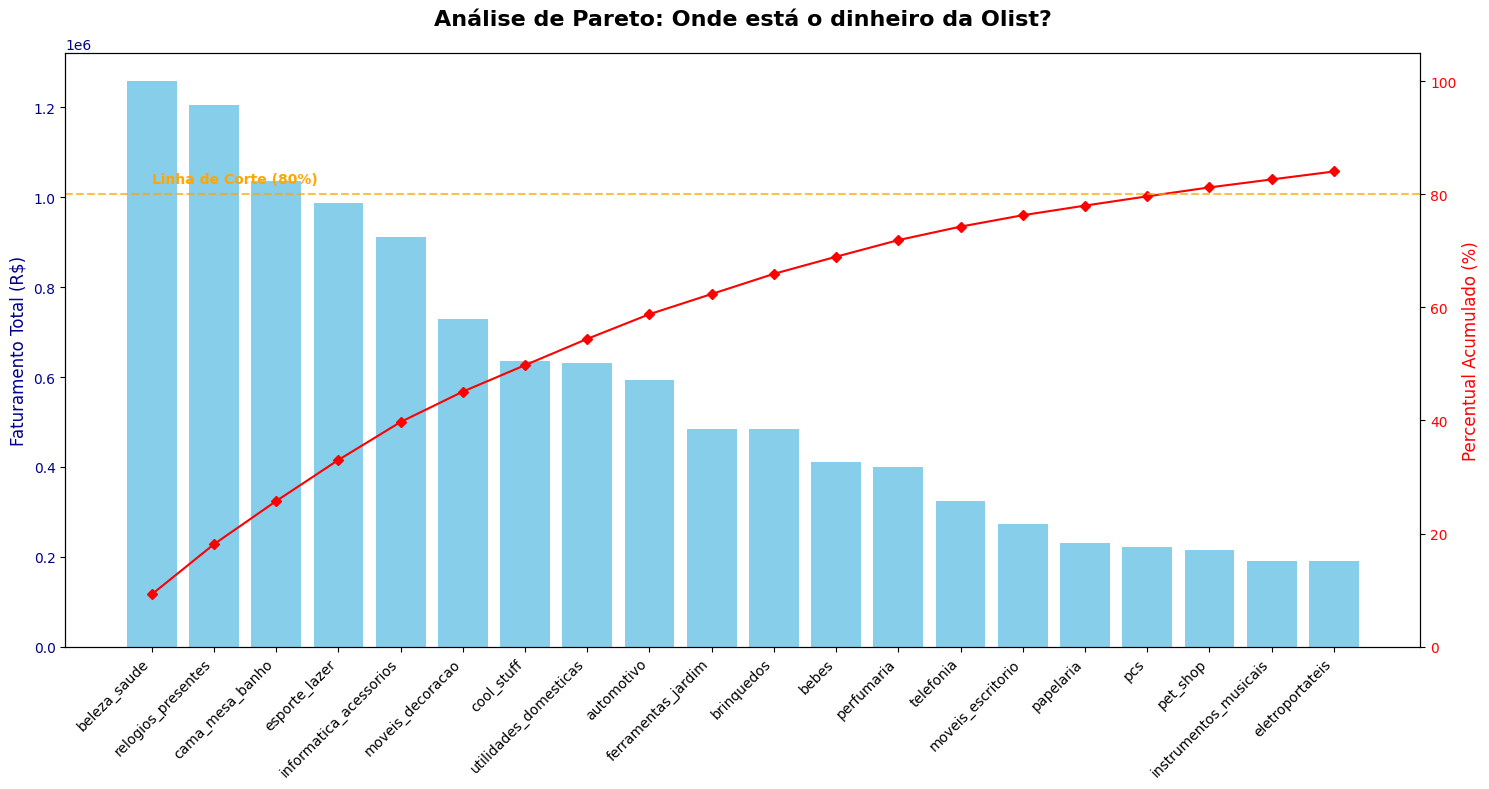

In [ ]:
# Gráfico de Pareto

import matplotlib.pyplot as plt

# 1. Preparando os dados (vamos focar no Top 20 para o gráfico não ficar poluído)
df_plot = df_abc.head(20)

# 2. Criando a base do gráfico
fig, ax1 = plt.subplots(figsize=(15, 8)) # Figura com 15p de largura e 8p
#de altura

# 3. Desenhando as Barras (Eixo Y da esquerda)
ax1.bar(df_plot['categoria'], df_plot['faturamento'], color='skyblue', label='Faturamento')
ax1.set_ylabel('Faturamento Total (R$)', color='darkblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='darkblue')

# Rotacionando os nomes das categorias para não ficarem amontoados
plt.xticks(rotation=45, ha='right')

# 4. Criando o segundo eixo (Eixo Y da direita) para a linha de %
ax2 = ax1.twinx()
ax2.plot(df_plot['categoria'], df_plot['percentual_acumulado'], color='red', marker='D', ms=5, label='% Acumulado')
ax2.set_ylabel('Percentual Acumulado (%)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 105) # Garante que o topo seja 100%

# 5. Adicionando a linha de corte dos 80% (Regra de Pareto)
ax2.axhline(80, color='orange', linestyle='--', alpha=0.7)
ax2.text(0, 82, 'Linha de Corte (80%)', color='orange', fontweight='bold')

# Finalização
plt.title('Análise de Pareto: Onde está o dinheiro da Olist?', fontsize=16, fontweight='bold', pad=20)
fig.tight_layout()
plt.show()

### Visualizando o Esquema do Banco de Dados

O código abaixo irá:
1.  Listar todas as tabelas no banco de dados `olist_projeto_final.db`.
2.  Para cada tabela, ele exibirá informações sobre suas colunas, indicando se são chaves primárias.
3.  Para cada tabela, ele também listará quaisquer chaves estrangeiras definidas.

In [ ]:
import sqlite3
import pandas as pd

# O objeto 'conn' já está disponível a partir da célula inicial, mas vamos garantir a conexão.
# Se a conexão 'conn' já estiver aberta, esta linha não a fechará e reabrirá desnecessariamente.
# Caso contrário, ela será estabelecida.
try:
    if 'conn' not in locals() or conn.closed:
        conn = sqlite3.connect(path + 'olist_projeto_final.db')
except AttributeError: # Happens if conn is None or not a valid connection object
    conn = sqlite3.connect(path + 'olist_projeto_final.db')


print("--- Esquema do Banco de Dados --- ")

# 1. Obter lista de tabelas
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

for table_name_tuple in tables:
    table_name = table_name_tuple[0]
    print(f"\n-- Tabela: {table_name} --")

    # 2. Informações das Colunas (inclui PK)
    print("  Colunas e Chave Primária:")
    df_columns = pd.read_sql(f"PRAGMA table_info({table_name});", conn)
    # Renomear colunas para melhor legibilidade
    df_columns = df_columns.rename(columns={'name': 'Nome_Coluna', 'type': 'Tipo', 'notnull': 'Nao_Nulo', 'pk': 'Chave_Primaria'})
    # Selecionar e exibir colunas relevantes
    display(df_columns[['Nome_Coluna', 'Tipo', 'Nao_Nulo', 'Chave_Primaria']])

    # 3. Chaves Estrangeiras (FK)
    print("  Chaves Estrangeiras:")
    df_fk = pd.read_sql(f"PRAGMA foreign_key_list({table_name});", conn)
    if not df_fk.empty:
        # Renomear colunas para melhor legibilidade
        df_fk = df_fk.rename(columns={
            'id': 'ID_FK', 'seq': 'Sequencia', 'table': 'Tabela_Referenciada',
            'from': 'Coluna_Local', 'to': 'Coluna_Referenciada', 'on_update': 'On_Update', 'on_delete': 'On_Delete'
        })
        display(df_fk[['Coluna_Local', 'Tabela_Referenciada', 'Coluna_Referenciada', 'On_Delete']])
    else:
        print("    Nenhuma chave estrangeira encontrada.")

print("------------------------------")

--- Esquema do Banco de Dados --- 

-- Tabela: orders --
  Colunas e Chave Primária:


,Nome_Coluna,Tipo,Nao_Nulo,Chave_Primaria
0,order_id,TEXT,0,0
1,customer_id,TEXT,0,0
2,order_status,TEXT,0,0
3,order_purchase_timestamp,TIMESTAMP,0,0
4,order_approved_at,TEXT,0,0
5,order_delivered_carrier_date,TEXT,0,0
6,order_delivered_customer_date,TIMESTAMP,0,0
7,order_estimated_delivery_date,TIMESTAMP,0,0


  Chaves Estrangeiras:
    Nenhuma chave estrangeira encontrada.

-- Tabela: items --
  Colunas e Chave Primária:


,Nome_Coluna,Tipo,Nao_Nulo,Chave_Primaria
0,order_id,TEXT,0,0
1,order_item_id,INTEGER,0,0
2,product_id,TEXT,0,0
3,seller_id,TEXT,0,0
4,shipping_limit_date,TEXT,0,0
5,price,REAL,0,0
6,freight_value,REAL,0,0


  Chaves Estrangeiras:
    Nenhuma chave estrangeira encontrada.

-- Tabela: customers --
  Colunas e Chave Primária:


,Nome_Coluna,Tipo,Nao_Nulo,Chave_Primaria
0,customer_id,TEXT,0,0
1,customer_unique_id,TEXT,0,0
2,customer_zip_code_prefix,INTEGER,0,0
3,customer_city,TEXT,0,0
4,customer_state,TEXT,0,0


  Chaves Estrangeiras:
    Nenhuma chave estrangeira encontrada.
------------------------------


In [ ]:
# consultas SQL para visualizar as tabelas e os dados

query_csvs = """
select * from products
"""
df_csv = pd.read_sql(query_csvs, conn)

display(df_csv.head())

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
